In [ ]:
!pip install -q rdata

In [ ]:
import rdata
from jax.numpy import sqrt, exp, power, linalg, linspace
import pandas as pd
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt

np = jnp

In [ ]:
parsed = rdata.parser.parse_file('ebola.rda')

# Convierte los objetos cargados a Python
dataframe = rdata.conversion.convert(parsed)

dataframe = next(iter(dataframe.values()))

dataframe['clin_signs'] = dataframe['clin_signs'].cumsum()
dataframe = dataframe.iloc[50:-20]
dataframe

,time,clin_signs,removals
51,50,1,0
52,51,1,0
53,52,1,0
54,53,1,0
55,54,1,0
...,...,...,...
168,167,291,0
169,168,291,0
170,169,291,3
171,170,291,0


In [ ]:
def regresion(xi, ai, b0i, b1i):
  """
    Regresion Logistica

    ai -> tope de la grafica
    b0i -> intercepto con el eje x
    b1i -> pendiente con el eje x
  """
  return ai / (1 + exp(-(b0i + b1i*xi)))

def calcular_jacobiano(arr_X, params):
  """
  Calcula el Jacobiano de la función 'regresion' para una lista de valores de xi.
  """
  # Define una función que toma los parámetros (ai, b0i, b1i, ci)
  # y devuelve el valor de la función 'regresion' para un xi dado
  def regresion_para_xi(params):
      return arr_X - regresion(arr_X, *params)

  # Calcula el Jacobiano de 'regresion_para_xi' usando jacfwd
  jacobiano = jacfwd(regresion_para_xi)(params)

  return jacobiano

def vector_residuo(arr_X, arr_Y, B):
  return arr_Y - regresion(arr_X, *B)

In [ ]:
def suma_de_errores_cuadrados(arr_X, arr_Y, B):
  vector = vector_residuo(arr_X, arr_Y, B)
  return sum([
      np.power(elem, 2) for elem in vector
  ])

def sanitizar_inversa(matrix, det_tol):
  if linalg.det(matrix) < det_tol:
    return linalg.pinv(matrix)

  return linalg.inv(matrix)

def Gauss_Newton(max_iter, tol, inicio, arr_X, arr_Y, det_tol):
  B = inicio
  valores_iteracion = []

  for i in range(max_iter):
    J = calcular_jacobiano(arr_X, B)
    JtJ_inv = sanitizar_inversa(np.dot(J.T, J), det_tol)
    JtJ_invJt = np.dot(JtJ_inv, J.T)

    B -= np.dot(JtJ_invJt, vector_residuo(arr_X, arr_Y, B))

    temp = suma_de_errores_cuadrados(arr_Y, arr_X, B)

    if i>1:
      if jnp.any(jnp.isnan(temp)): break
      if abs(valores_iteracion[-1] - valores_iteracion[-2]) < tol: break

    valores_iteracion.append(temp)
    print("Iteracion:", i, "\tError Cuadrado:", temp)

  return B, valores_iteracion

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Iteracion: 0 	Error Cuadrado: 1564803.6404579063
Iteracion: 1 	Error Cuadrado: 1533563.0652308543
Iteracion: 2 	Error Cuadrado: 1620779.7953704554
Iteracion: 3 	Error Cuadrado: 1614414.537921915
Iteracion: 4 	Error Cuadrado: 1612896.1283397074
Iteracion: 5 	Error Cuadrado: 1612674.28546839
Iteracion: 6 	Error Cuadrado: 1612651.4210203341
Iteracion: 7 	Error Cuadrado: 1612649.1507686605
Iteracion: 8 	Error Cuadrado: 1612649.191451264
Iteracion: 9 	Error Cuadrado: 1612649.191451264
Resuelto en 10 iteraciones
Respuesta: [ 2.9495993e+02 -1.1437317e+01  9.3812570e-02]


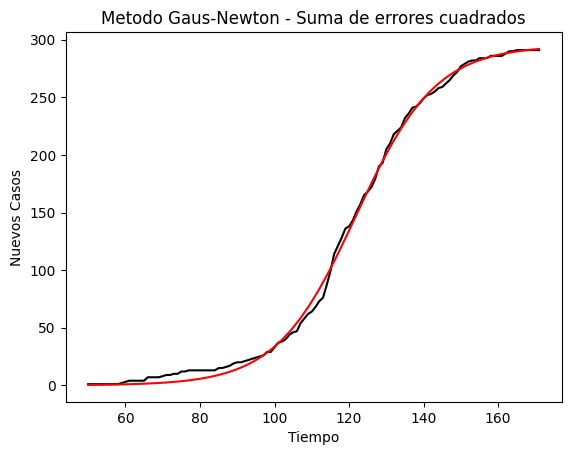

In [ ]:
arr_X = jnp.array(dataframe['time'].values.astype(np.float64))
arr_Y = jnp.array(dataframe['clin_signs'].values.astype(np.float64))

iteraciones = 50
inicio = jnp.array([300, 1, 0]).astype(np.float64)
det_tol = 1e-12

B, error_gauss = Gauss_Newton(iteraciones, 1e-8, inicio, arr_X, arr_Y, det_tol)

new_X = linspace(arr_X[0], arr_X[-1])
new_Y_gauss = regresion(new_X, *B)

plt.plot(arr_X, arr_Y, color='black')
plt.plot(new_X, new_Y_gauss, color='red')
plt.title(f"Metodo Gaus-Newton - Suma de errores cuadrados")
plt.xlabel('Tiempo')
plt.ylabel('Nuevos Casos')

print("Resuelto en", len(error_gauss), "iteraciones")
print("Respuesta:", B)
plt.show()